In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import bilby
import gwpy.timeseries
from scipy.io import loadmat
from scipy.interpolate import interp1d

import sys
sys.path.insert(0,'../src')
from util import *
from cross_correlation import *
from postprocessing import *
from pe import *
from constants import *

In [4]:
matplotlib.rcParams.update({'font.size':15})

In [5]:
##################
# Inputs     
##################

signalType='arbitrary' #Need to choose between 'white' (meaning alpha=3) and 'arbitrary' (any other alpha)
noiseType='LIGO O2' #Need to choose between 'LIGO O2' and 'white'

NSegments         = 15

#Don't change anything of the following parameters
Fs                = 1024. # Hz
segmentDuration   = 64.0 # s
t0                = 0 # s
TAvg              = 4.0 # s

####################
# Computed quantities
####################

NSamplesPerSegment=int(segmentDuration*Fs) 
deltaT=1/Fs
fNyquist=1/(2*deltaT)
deltaF=1/segmentDuration
deltaFStoch=1/TAvg
NAvgs = 2 * int(segmentDuration / TAvg) - 1
jobDuration = NSegments * segmentDuration
N = NSegments*NSamplesPerSegment   #Total number of samples

###################
# Signal properties
###################

fref = 25   #reference frequency (Hz)
alpha = 0  #spectral index

#Still have to make the definitions below more user-friendly...

#When using arbitrary alpha, define OmegaRef:
OmegaRef=1e-5 #Amplitude GW spectrum as in h^2Omega=OmegaRef*(f/fref)**alpha
sigma             = np.sqrt(512 * 1e-42) # noise amplitude in case of white noise

#When using white signal, define sigma_inj:
sigma_inj         = sigma/3. #Will have flat PSD spectrum with amplitude 2*sigma_inj**2/Fs

M = 2   #Total number of detectors. Code is written explicitly for 2 detectors (e.g. ORF's, PSD, ...) but can be 
        #generalized easily

H_theor = (3*H0**2)/(10*np.pi**2)

In [6]:
Pgw_theor = 2*(sigma_inj**2)/Fs

Y_theor = Pgw_theor/(H_theor/fref**3)

In [7]:
# Discrete times
T = N*deltaT
t = np.array([t0 + deltaT*i for i in range(int(N))])

if N%2==0:
    numFreqs = N/2-1
else:
    numFreqs = (N-1)/2

#Discrete positive frequencies
deltaF = 1/(N*deltaT)
f = np.array([deltaF*(i+1) for i in range(int(numFreqs))])

# Normalization
if signalType=='white':
    norm = np.sqrt(N/(2*deltaT))*np.sqrt(2*(sigma_inj**2)*deltaT)
elif signalType=='arbitrary':
    norm = np.sqrt(N/(2*deltaT))*np.sqrt(H_theor)*np.sqrt(OmegaRef)
    norm*=f**((alpha-3)/2)/(fref**(alpha/2))
else:
    raise ValueError("Please specify the correct type of signal")

In [8]:
# Interpolate ORF for two LIGO detectors -- Can be generalized for other detectors
orf_file='../src/orfs/ORF_HL.dat'

datContent = [i.strip().split() for i in open(orf_file).readlines()]

x=[float(datContent[i][0]) for i in range(len(datContent))]
y=[float(datContent[i][1]) for i in range(len(datContent))]

orf_f = interp1d(x, y, kind='cubic')

def orf_func(x):
    if x<10:
        return orf_f(10)
    else:
        return orf_f(x)

In [9]:
# Implement ORF frequency dependence here -- Can be generalized to other/more detectors

gamma11=np.ones(int(numFreqs)) #Response function for detector 1
gamma22=np.ones(int(numFreqs)) #Response function for detector 2
gamma12=np.array([orf_func(i) for i in f]) #ORF. If do not want to include ORF, use same method but with orf_func(i)
                                            #replaced with 1's

C=[]
for i in range(len(gamma11)):
    C.append(np.array([[gamma11[i],gamma12[i]],[gamma12[i],gamma22[i]]]))
C=np.array(C) #Correlation matrix for each of the frequencies. Has shape (numFreqs,M,M) with M=2 for two detectors

eigval,eigvec=np.linalg.eig(C) #Compute eigenvalues and eigenvectors of C for each frequency

eigval=np.array([np.diag(x) for x in eigval]) #Array with diagonal M x M matrices containing the eigenvalues

In [10]:
#Make LIGO (H+L) noise PSD function -- Can be generalized to any PSD by using different txt file as input

file=open("PSD_H1.txt","r")

freqListH1=[]
freqListL1=[]
PSDListH1=[]
PSDListL1=[]
for line in file:
    freqListH1.append(float(line.split(" ")[0]))
    PSDListH1.append(float(line.split(" ")[1]))
    
file1=open("PSD_L1.txt","r")
for line in file1:
    freqListL1.append(float(line.split(" ")[0]))
    PSDListL1.append(float(line.split(" ")[1]))
    
PSDFuncH1=interp1d(freqListH1,PSDListH1, kind='cubic')
PSDFuncL1=interp1d(freqListL1,PSDListL1, kind='cubic')

In [11]:
#This ensures the noise we add will have the proper normalization

normPSDH1=np.sqrt(N/(2*deltaT))*np.sqrt(np.abs(PSDFuncH1(f)))
normPSDL1=np.sqrt(N/(2*deltaT))*np.sqrt(np.abs(PSDFuncL1(f)))

normPSD=[normPSDH1,normPSDL1]

In [12]:
# Need to simulate multiple time-series to avoid periodicity
y=np.zeros((3,M),dtype=np.ndarray)
for kk in range(3):
    # Loop over detectors
    z=np.zeros((int(numFreqs),M),dtype = 'complex_')
    for ii in range(M):
        # Construct real and imaginary parts, with random phases (uncorrelated)
        re = (norm/np.sqrt(2))*np.random.randn(int(numFreqs))
        im = (norm/np.sqrt(2))*np.random.randn(int(numFreqs))
        z[:,ii] = re+1j*im
    
    #Add noise (for now, normalization corresponds to LIGO noise PSD)
    if noiseType=='LIGO O2':
        znoise=np.zeros((int(numFreqs),M),dtype = 'complex_')
        for ii in range(M):
            # Construct real and imaginary parts, with random phases (uncorrelated)
            re = (normPSD[ii]/np.sqrt(2))*np.random.randn(int(numFreqs))
            im = (normPSD[ii]/np.sqrt(2))*np.random.randn(int(numFreqs))
            znoise[:,ii] = re+1j*im
        
    # Transform from uncorrelated z to correlated x:
    xtemp=np.zeros((int(numFreqs),M),dtype = 'complex_')
    for ii in range(int(numFreqs)):
        xtemp[ii,:] = (z[ii]).dot(np.sqrt(eigval[ii]).dot(eigvec[ii].transpose())) #This ensures data is correlated properly
        if noiseType=='LIGO O2':
            xtemp[ii,:] += znoise[ii,:] #This means noise isn't correlated + comes from two different PSD's (H1 and L1)
        
    for ii in range(M):
        # Set DC and Nyquist = 0, then add negative freq parts in proper order
        if N%2==0:
            # Note that most negative frequency is -f_Nyquist when N=even
            xtilde = np.concatenate((np.array([0]),xtemp[:,ii],np.array([0]),np.flipud(np.conjugate(xtemp[:,ii]))))
        else:
            # No Nyquist frequency when N=odd
            xtilde = np.concatenate((np.array([0]),xtemp[:,ii],np.flipud(np.conjugate(xtemp[:,ii]))))
        # Fourier transform back to time domain and take real part (imag part = 0)
        y[kk][ii]=np.real(np.fft.ifft(xtilde))

In [13]:
# Splice together the data using sinusoids of twice the period (way of putting together three datasets from above,
# again to avoid periodicity due to the IFFT)
w=np.zeros(N)
for ii in range(N):
    w[ii]=np.sin(np.pi * ((ii+1)-1)/N)
    
xdata=np.zeros(M,dtype=np.ndarray)

for ii in range(M):
    y0 = w*y[0][ii]
    y1 = w*y[1][ii]
    y2 = w*y[2][ii]
    
    z0=np.concatenate((y0[int(N/2):N],np.zeros(int(N/2))))
    z1=y1[:]
    z2=np.concatenate((np.zeros(int(N/2)),y2[0:int(N/2)]))
    
    xdata[ii] = z0 + z1 + z2 #Correlated strain data for ii-th detector
    
    #If instead of a noise PSD from LIGO, one wanted to add white noise with amplitude sigma, 
    #this can be done directly in the time domain here:
    if noiseType=='white':
        xdata[ii] += sigma*np.random.randn(int(N)) #Adding Gaussian, white noise to the strain

In [14]:
d1=TimeSeries(t,xdata[0])
d2=TimeSeries(t,xdata[1])

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/plot/axes.py:75: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(self, **kw)


Text(0.5, 1.0, 'Power spectral density')

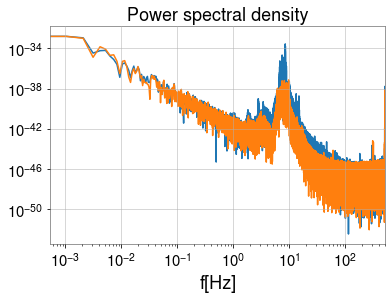

In [15]:
nperseg=int(d1.Fs/deltaF)
freqs,P1_test = welch_psd(d1.data,nperseg=nperseg,window='Hann',fs=d1.Fs)
freqs,P2_test = welch_psd(d2.data,nperseg=nperseg,window='Hann',fs=d2.Fs)

fig0,axs0=plt.subplots()
axs0.loglog(freqs,P1_test,label='Data 1')
axs0.loglog(freqs,P2_test,label='Data 2')
axs0.set_xlim(freqs[0],freqs[-1])
#axs0.set_ylim(1e-47,1e-43)
#axs0.legend()
axs0.set_xlabel('f[Hz]')
axs0.set_title('Power spectral density')

## Stochastic CC search

In [16]:
# run stochastic pipeline
alpha=0 #This alpha simply follows from cross-corelation statistic, don't change even for other spectral alphas
fref=25
Y_t,sig_t,Y_ft,var_ft,segmentStartTimes,freqs=cross_correlation(d1,d2,segmentDuration,deltaFStoch,orf_file='../src/orfs/ORF_HL.dat',
                                                      fref=fref,alpha=alpha,fmin=deltaFStoch,fmax=fNyquist/2.)

../src/cross_correlation.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_ft[:, II], var_ft[:, II] = Y_f.data, var_f.data
../src/cross_correlation.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  


stochastic: Done with Interval 1 / 25
	Y     = 9.070265e-06
	sigma = 2.134224e-06
	SNR   = 4.249912
stochastic: Done with Interval 2 / 25
	Y     = 1.296682e-05
	sigma = 2.089416e-06
	SNR   = 6.205953
stochastic: Done with Interval 3 / 25
	Y     = 1.230838e-05
	sigma = 2.180335e-06
	SNR   = 5.645178
stochastic: Done with Interval 4 / 25
	Y     = 1.105685e-05
	sigma = 2.078660e-06
	SNR   = 5.319224
stochastic: Done with Interval 5 / 25
	Y     = 1.031248e-05
	sigma = 1.874880e-06
	SNR   = 5.500341
stochastic: Done with Interval 6 / 25
	Y     = 1.194283e-05
	sigma = 1.994926e-06
	SNR   = 5.986606
stochastic: Done with Interval 7 / 25
	Y     = 1.145911e-05
	sigma = 2.117456e-06
	SNR   = 5.411735
stochastic: Done with Interval 8 / 25
	Y     = 6.765384e-06
	sigma = 2.085838e-06
	SNR   = 3.243485
stochastic: Done with Interval 9 / 25
	Y     = 8.510723e-06
	sigma = 1.858529e-06
	SNR   = 4.579279
stochastic: Done with Interval 10 / 25
	Y     = 8.024957e-06
	sigma = 2.030221e-06
	SNR   = 3.952750

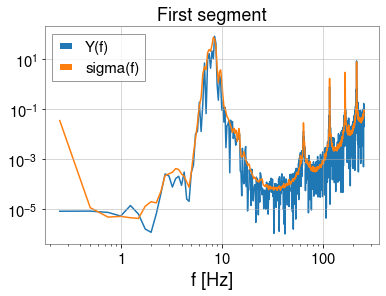

In [17]:
# plot results of CC search
fig,axs=plt.subplots()
axs.loglog(freqs,np.abs(Y_ft[:,0]),label='Y(f)')
axs.loglog(freqs,np.abs(np.sqrt(var_ft[:,0])),label=('sigma(f)'))
#axs.loglog(freqs,freqs**(3)/100000,label=('~f³'))
axs.legend()
axs.set_xlabel('f [Hz]')
axs.set_title('First segment')
plt.show()
# Note that you get the expected f³ dependence for both the CC and sigma (see 3 and 4 in O2). Indeed,if orf=1 and 
# signal is flat, only expect the frequency dependency from S_0(f).

In [18]:
Y_f,var_f=postprocessing_spectra(Y_ft,var_ft,jobDuration,segmentDuration,
                                 deltaFStoch,deltaT)

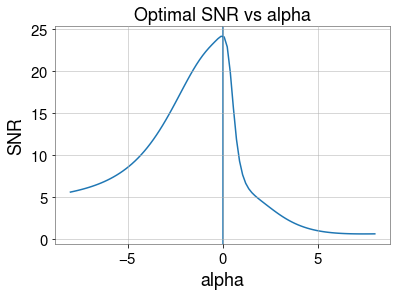

In [19]:
# test optimal filtering

alphas=np.linspace(-8,8,100)

snrs=np.zeros(alphas.shape)
for ii,a in enumerate(alphas):
    y,s=calc_Y_sigma_from_Yf_varf(np.real(Y_f),
                          var_f,
                          freqs=freqs,
                          alpha=a,
                          fref=25)
    snrs[ii]=y/s
fig1,axs1=plt.subplots()
axs1.plot(alphas,snrs)
axs1.axvline(0)
axs1.set_xlabel('alpha')
axs1.set_ylabel('SNR')
axs1.set_title('Optimal SNR vs alpha')
plt.show()

00:15 bilby INFO    : Running for label 'GWB_powerlaw', output will be saved to 'outdir'
00:15 bilby INFO    : Search parameters:
00:15 bilby INFO    :   A = LogUniform(minimum=1e-13, maximum=0.01, name='A', latex_label='A', unit=None, boundary=None)
00:15 bilby INFO    :   alpha = Gaussian(mu=0, sigma=3.5, name='alpha', latex_label='alpha', unit=None, boundary=None)
00:15 bilby INFO    : Single likelihood evaluation took 3.359e-04 s


0it [00:00, ?it/s]

00:15 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f5aac5f9790>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 10000, 'nact': 5}
00:15 bilby INFO    : Checkpoint every check_point_delta_t = 600s
00:15 bilby INFO    : Using dynesty version 1.0.1
00:15 bilby INFO    : Using the bilby-implemented rwalk samp

6170it [01:55, 42.48it/s, bound:722 nc: 50 ncall:2.4e+05 eff:2.6% logz-ratio=282.26+/-nan dlogz:0.100>0.1]   

00:17 bilby INFO    : Written checkpoint file outdir/GWB_powerlaw_resume.pickle
00:17 bilby INFO    : Writing 1429 current samples to outdir/GWB_powerlaw_samples.dat
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:17 bilby WARNING : Axis limits cannot be NaN or Inf
00:17 bilby WARNING : Failed to create dynesty run plot at checkpoint


6170it [02:01, 50.70it/s, bound:722 nc:  1 ncall:2.4e+05 eff:2.8% logz-ratio=282.35+/-nan dlogz:0.000>0.1]



00:17 bilby INFO    : Sampling time: 0:01:55.164229
00:17 bilby INFO    : Summary of results:
nsamples: 6670
ln_noise_evidence: 5505.562
ln_evidence: 5787.915 +/- 9433097.656
ln_bayes_factor: 282.353 +/- 9433097.656



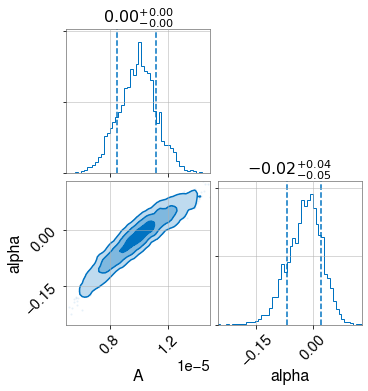

In [20]:
# A few simple setup steps
label = 'GWB_powerlaw'
outdir = 'outdir'

cleanup_dir(outdir)

Amin,Amax=1e-13,1e-2
    
alpha_fixed=3
    
fref=25

likelihood = BasicPowerLawGWBLikelihood(Y_f[1:],var_f[1:],freqs[1:],fref)
priors = dict(A=bilby.core.prior.LogUniform(Amin,Amax, 'A'),
              alpha=bilby.core.prior.Gaussian(0,3.5, 'alpha'))

#injection_parameters=dict(A=Y_theor,alpha=3)

# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=500,
    walks=10, outdir=outdir, label=label,maxmcmc=10000)
result.plot_corner()

In [21]:
# extract samples

A1=result.samples[:,0]

Text(0, 0.5, 'Posterior probability density')

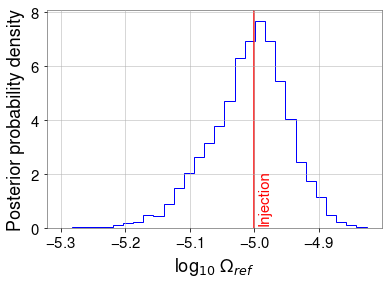

In [22]:
x=np.linspace(Amin,Amax,10)

plt.hist(np.log10(A1),bins=30,histtype='step',color='blue',density=True,label='')
plt.axvline(-5,color='red')
plt.text(-4.995,.2,'Injection',rotation=90,color='red')

plt.xlabel('log$_{10}$ \u03A9$_{ref}$')
#plt.title('')
plt.ylabel('Posterior probability density')